<a href="https://colab.research.google.com/github/hasitanalluri/mlgroupproject/blob/main/ML_Final_Project_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overall Question: What data can government agencies such as the CDC collect to effectively predict hospital strain?

Specific Questions:
1.   Can we predict whether a state will experience significant staff shortages (hospital strain) using collectible data?
2.   If so, which features in our dataset are most important for predicting hospital strain (drive hospital strain)?




In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We downloaded our dataset from https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh/about_data
df = pd.read_csv('/content/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20250227.csv')
#print(df.head())

In [70]:
# Create new variable, proportion of hospitals experiencing critical staffing shortages
df['critical_staffing_shortage_today_prop'] = df['critical_staffing_shortage_today_yes'] / (df['critical_staffing_shortage_today_yes'] + df['critical_staffing_shortage_today_no'])
print("Original df size:", df.shape)
print(df[['critical_staffing_shortage_today_prop']].isnull().any(axis=1).sum())
df = df.dropna(subset=['critical_staffing_shortage_today_prop']) # Remove missing values
print("New df size:", df.shape)

Original df size: (81713, 136)
10880
New df size: (70833, 136)


In [71]:
# Clean data for the number of inpatient beds utilized (inpatient_beds_utilization)
print("Original df size:", df.shape)
print(df[['inpatient_beds_utilization']].isnull().any(axis=1).sum())
df = df.dropna(subset=['inpatient_beds_utilization']) # Remove missing values
print("New df size:", df.shape)

Original df size: (70833, 136)
0
New df size: (70833, 136)


In [72]:
columns_with_missing = df.columns[df.isnull().any()]
#print(columns_with_missing)
print(df.shape)
# Drop all columns with missing values
df = df.dropna(axis=1)
print(df.shape)

(70833, 136)
(70833, 66)


In [73]:
# Normalize all numerical variables
from sklearn.preprocessing import MinMaxScaler

# Create a scaler
scaler = MinMaxScaler()

# Select only numerical columns
num_cols = df.select_dtypes(include=['number']).columns

# Fit and transform the numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

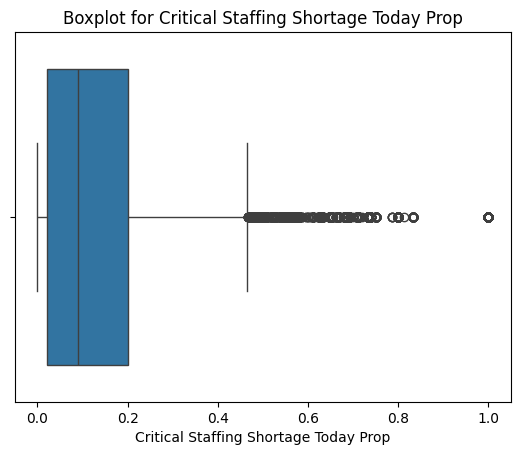

count    70833.000000
mean         0.149883
std          0.193110
min          0.000000
25%          0.021978
50%          0.090000
75%          0.200000
max          1.000000
Name: critical_staffing_shortage_today_prop, dtype: float64


In [74]:
# Logistic regression to predict hospital strain
# Determine criteria for high and low strain

# Boxplot
sns.boxplot(x=df['critical_staffing_shortage_today_prop'])
plt.title('Boxplot for Critical Staffing Shortage Today Prop')
plt.xlabel('Critical Staffing Shortage Today Prop')
plt.show()

# Five-number summary
five_num_summary = df['critical_staffing_shortage_today_prop'].describe()
print(five_num_summary)

75% is 0.2, meaning that 75% of all hospitals in a state that day are experiencing a critical staff shortage of 20% or less. We will define 'high strain' as when a state is in the upper quartile for critical_staffing_shortage_today_prop, meaning more than 20% of hospitals in that state on that day are experiencing a critical staffing shortage.

In [75]:
# Create variable, strain
df['strain'] = (df['critical_staffing_shortage_today_prop'] > 0.2).astype(int)

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.select_dtypes(include=['number'])
X = X.drop(['critical_staffing_shortage_today_prop',
             'critical_staffing_shortage_today_yes',
             'critical_staffing_shortage_today_no', 'strain'], axis=1)

# Include state as variable in log model
df_dummies = pd.get_dummies(df['state'],dtype='int')
df = df.dropna(subset=['state'])
X = pd.concat([X, df_dummies], axis=1)

y = df['strain'] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LogisticRegression(penalty=None,
                         fit_intercept=True,
                         solver='newton-cholesky',
                         max_iter=1000).fit(X_train, y_train)

print('Accuracy on training data: ', reg.score(X_train, y_train))
print('Accuracy on test data: ', reg.score(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_glm/_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.14603e-17): result may not be accurate.
  warnings.warn(


Accuracy on training data:  0.8923163801927082
Accuracy on test data:  0.8887555586927366


Logistic regression worked very well to predict strain on hospitals!

In [106]:
coef_df = pd.DataFrame({'Variable': reg.feature_names_in_, 'Coefficient': reg.coef_[0]})

# Add a column for absolute value of coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort by absolute coefficient value and take top 20
top_20 = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)

# Positive coefficients
positive_coef = top_20[top_20['Coefficient'] > 0][['Variable', 'Coefficient']]

# Negative coefficients
negative_coef = top_20[top_20['Coefficient'] < 0][['Variable', 'Coefficient']]

In [107]:
positive_coef.head(10)

,Variable,Coefficient
57,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,76.815907
1,critical_staffing_shortage_anticipated_within_week_yes,53.235270
48,previous_day_deaths_covid_and_influenza_coverage,40.082688
52,all_pediatric_inpatient_bed_occupied_coverage,37.379812
21,total_pediatric_patients_hospitalized_confirmed_covid_coverage,25.711876
39,previous_day_admission_adult_covid_suspected_40-49_coverage,22.828510
103,SC,22.247429
18,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,18.618257
19,total_adult_patients_hospitalized_confirmed_covid_coverage,18.043340
13,previous_day_admission_pediatric_covid_confirmed_coverage,17.664662


In [108]:
negative_coef.head(10)

,Variable,Coefficient
54,previous_day_admission_pediatric_covid_confirmed_0_4_coverage,-61.926684
50,total_patients_hospitalized_confirmed_influenza_and_covid_coverage,-44.223620
2,critical_staffing_shortage_anticipated_within_week_no,-29.218539
5,hospital_onset_covid_coverage,-27.712648
34,previous_day_admission_adult_covid_confirmed_80+_coverage,-26.864716
36,previous_day_admission_adult_covid_suspected_18-19_coverage,-24.473076
59,staffed_pediatric_icu_bed_occupancy_coverage,-23.415063
27,previous_day_admission_adult_covid_confirmed_18-19_coverage,-21.655999
16,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,-17.584412
56,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,-17.122947


In [62]:
# Use random forests to determine what features are driving strain
from sklearn.ensemble import RandomForestRegressor

# Fit model:
model = RandomForestRegressor(max_depth=10) # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

In [63]:
print( 'Rsq: ', rf.score(X_test,y_test) ) # Rsq measure

Rsq:  0.8175493411659145


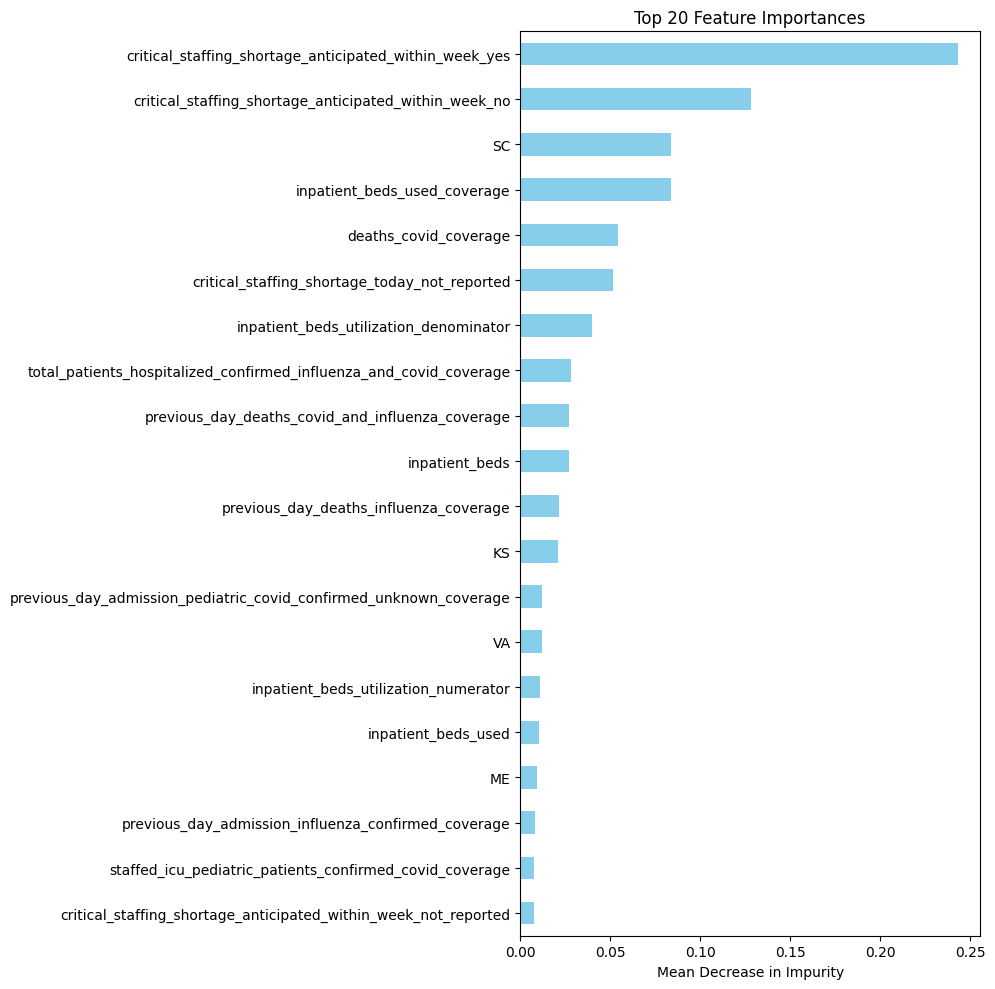

In [67]:
# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Select top 10 features
top_10_features = feature_importances.sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 10))
top_10_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 20 Feature Importances')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
plt.show()